In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import geopandas as gpd
import cartopy
import xarray as xr
import cartopy.crs as ccrs

from time import time
from sklearn.utils import Bunch
from sklearn.datasets import fetch_species_distributions
from sklearn import svm, metrics
import netCDF4

Idea: Make raster layers out of species composition data and environmental layers
X is temp, salinity, oxygen, nitrate, chlorophyll, and pH + phytobase
1. Find data sources for X variable climatologies (need 2D grids over the same area) 
2. *VISUALIZE LAYERS*
3. Modify exising CNN species distribution code with my X and Y
4. Train and predict


# To plot on SO
- Check dimensions of data array
- Make dx, dy grid
- Use rest of NSIDC code to grid

In [2]:
def so_ax():
  map_proj = ccrs.SouthPolarStereo()
  fig = plt.figure(figsize=[5, 5])  # inches
  ax = plt.subplot(projection=map_proj)
  ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
  fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, wspace=0.02)
  return ax 

In [8]:
# Inspect salinity at time=10 (5 years x 6 months/year avg = 30 total) and depth = 25m
sal = xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_Salt.nc')
sal['SALT'][10, 25, :, :]

<xarray.DataArray 'SALT' (YC: 588, XC: 2160)>
[1270080 values with dtype=float32]
Coordinates:
    iter     int64 ...
    time     datetime64[ns] 2013-12-01T04:00:00
  * XC       (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float32 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
    Z        float32 -327.0
    Depth    (YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    drF      float32 ...
    hFacC    (YC, XC) float32 ...
Attributes:
    units:          psu
    long_name:      Salinity
    standard_name:  SALT

In [16]:
xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_O2.nc')

<xarray.Dataset>
Dimensions:  (time: 72, XC: 2160, YC: 588, Z: 52)
Coordinates:
    iter     (time) int64 ...
  * time     (time) datetime64[ns] 2013-01-30T20:40:00 ... 2018-12-31T10:20:00
  * XC       (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.4 359.6 359.8 359.9
  * YC       (YC) float32 -77.98 -77.95 -77.91 -77.88 ... -30.02 -29.87 -29.72
  * Z        (Z) float32 -2.1 -6.7 -12.15 -18.55 ... -5e+03 -5.4e+03 -5.8e+03
    Depth    (YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    drF      (Z) float32 ...
    hFacC    (Z, YC, XC) float32 ...
Data variables:
    TRAC03   (time, Z, YC, XC) float32 ...

[]

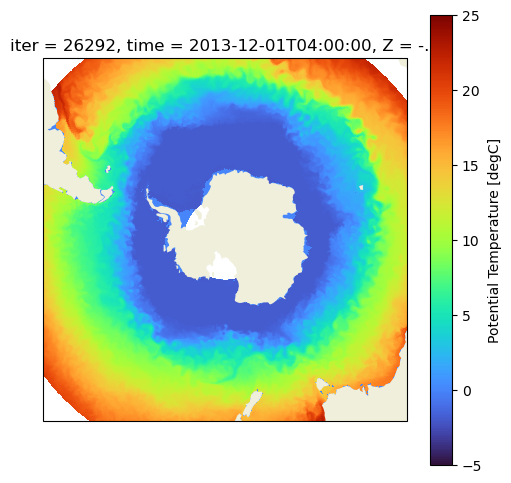

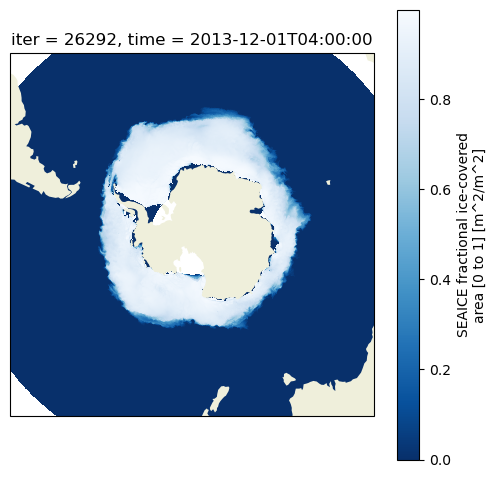

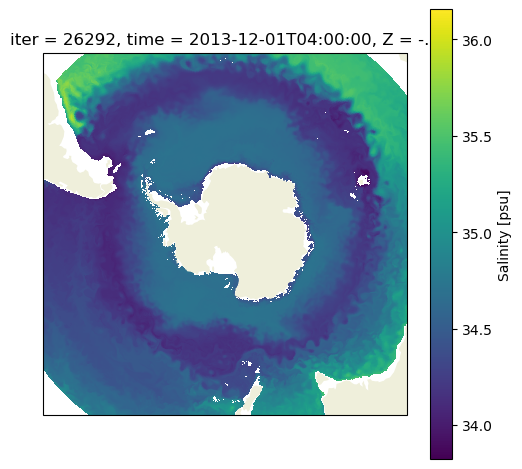

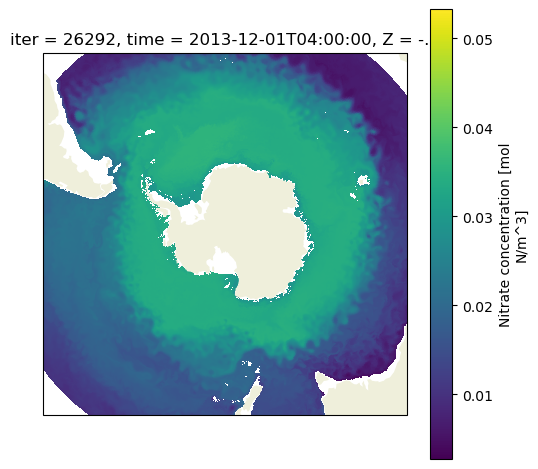

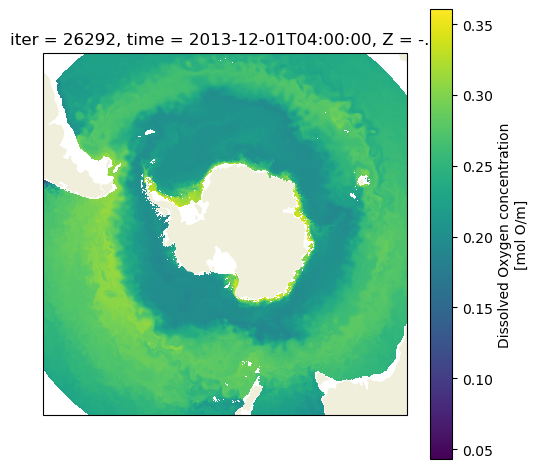

In [24]:
ax = so_ax()
temperature = xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_Theta.nc')
temperature['THETA'][10, 0, : , :].plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', vmin=-5, vmax=25)
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
sie = xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_SeaIceArea.nc')
sie['SIarea'][10, : , :].plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap='Blues_r')
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
sal = xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_Salt.nc')
sal = sal['SALT'][10, 25, :, :]
sal = sal.where(sal > 0)
sal.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
no3 = xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_NO3.nc')
no3 = no3['TRAC04'][10, 25, :, :]
no3 = no3.where(no3 > 0)
no3.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

ax = so_ax()
o2 = xr.open_dataset('../../data/in/bsose/bsose_i133_2013to2018_monthly_O2.nc')
o2 = o2['TRAC03'][10, 25, :, :]
o2 = o2.where(o2 > 0)
o2.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap='viridis')
ax.add_feature(cartopy.feature.LAND, zorder=2)
ax.plot()

In [2]:
phytobase = pd.read_csv("../../data/in/datasets/unmodified/Phytoplankton_harmonized_database_revised.csv")

C:\Users\Ayush Nag\AppData\Local\Temp\ipykernel_4248\2653630108.py:1: DtypeWarning: Columns (4,32,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  aus_data = pd.read_csv("../../data/in/datasets/unmodified/The_Australian_Phytoplankton_Database_(1844_-_2016)_-_abundance_and_biovolume_(SUPERSEDED_BY_ONGOING_COLLECTION).csv")


In [3]:
phytobase.columns

Index(['FID', 'ID', 'RECORD_ID', 'PROJECT_ID', 'SAMPLE_ID', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'SAMPLE_TIME_UTC', 'SAMPLE_YEAR',
       'SAMPLE_MONTH', 'SAMPLE_DAY', 'DATE_RESOLUTION', 'SAMPLE_DEPTH',
       'FUNCTIONAL_GROUP', 'TAXON_NAME', 'FAMILY', 'GENUS', 'SPECIES',
       'CELLS_L', 'PRESENCE_ABSENCE', 'BIOVOLUME_SHAPE', 'BIOVOLUME_UM3_L',
       'geom', 'PROJECT_DESCRIPTION', 'CUSTODIAN_DETAILS', 'START_DATE',
       'END_DATE', 'NO_SAMPLES', 'NO_RECORDS', 'RESOLUTION', 'SAMPLE_METHOD',
       'IDENTIFICATION_METHOD', 'MAGNIFICATION', 'PRESERVATIVE', 'CITATION'],
      dtype='object')

In [4]:
phytobase['TAXON_NAME'].value_counts()[:3]

Prorocentrum spp.    18135
Dictyocha fibula     17636
Rhizosolenia spp.    17469
Name: TAXON_NAME, dtype: int64